In [1]:
import numpy as np
import json, os
## import spearmanr
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_mutual_info_score, v_measure_score, adjusted_rand_score, normalized_mutual_info_score, homogeneity_completeness_v_measure
import pandas as pd
from scipy.cluster import hierarchy

In [2]:
## ambiguity load
with open("./sampling/key_to_ambiguity.json", "r") as f:
	key_to_ambiguity = json.load(f)

with open("./sampling/key_to_xmeans_ambiguity.json", "r") as f:
	key_to_xmeans_ambiguity = json.load(f)

with open("./sampling/key_to_hdbscan_ambiguity.json", "r") as f:
	key_to_hdbscan_ambiguity = json.load(f)

with open("./sampling/key_to_dbscan_ambiguity.json", "r") as f:
	key_to_dbscan_ambiguity = json.load(f)

with open("./sampling/key_to_birch_ambiguity.json", "r") as f:
	key_to_birch_ambiguity = json.load(f)

with open("./sampling/sampled_datasets_training.json", "r") as f:
	sampled_datasets_training = json.load(f)



for dataset in sampled_datasets_training:

	del key_to_ambiguity[dataset + ".npy"]
	del key_to_xmeans_ambiguity[dataset + ".npy"]
	del key_to_hdbscan_ambiguity[dataset + ".npy"]
	del key_to_dbscan_ambiguity[dataset + ".npy"]
	del key_to_birch_ambiguity[dataset + ".npy"]



keys = list(key_to_ambiguity.keys())
ambiguities = np.array(list(key_to_ambiguity.values()))
xmeans_ambiguity = np.array([key_to_xmeans_ambiguity[key] for key in keys])
hdbscan_ambiguity = np.array([key_to_hdbscan_ambiguity[key] for key in keys])
dbscan_ambiguity = np.array([key_to_dbscan_ambiguity[key] for key in keys])
birch_ambiguity = np.array([key_to_birch_ambiguity[key] for key in keys])

In [3]:
## study result load

study_result = []
for part in os.listdir("./study_result/"):
	if part[-5:] == ".json":
		with open(f"./study_result/{part}", "r") as f:
			study_result.append(json.load(f))


In [4]:
### demographic analysis
male_female = [0, 0]
age = []
job = []
major = []
for study_result_single in study_result:
  demo = study_result_single["demographic"]
  if demo["gender"] == "male":
    male_female[0] += 1
  else:
    male_female[1] += 1
  age.append(demo["age"])
  job.append(demo["job"])
  major.append(demo["major"])

age = np.array(age, dtype=np.int32)
print(male_female)
print(np.mean(age), np.std(age), np.min(age), np.max(age))
print(job)
print(major)

[13, 5]
27.166666666666668 2.6718699236468995 23 33
['Student', 'Graduate student', 'Student', 'Professor', 'Student', 'HCI Researcher', 'Student', 'Graduate Student', 'Graduate Student', 'Ph.D. student', 'engineer', 'Student', 'PhD Student', 'Graduate student', 'Graduate Research Assistant', 'Graduate Student', 'Data Visualization', 'Ph.D. student']
['AI Converge', 'Computer Science', 'CS', 'Computer Science', 'Computer Science', 'Computer Science and Engineering', 'Computer Science ', 'Computer Science & Engineering', 'Computer Science', 'Civil and Environmental Engineering', 'cs', 'Computer Science', 'Computer Science', 'Mathematics', 'Computer Science & Engineering', 'Computer Science', 'Computer Science', 'Computer Science']


In [5]:
## user-selected ambiguity
user_selected_ambiguity = np.zeros(len(keys))
for result in study_result:

	for i, key in enumerate(keys):
		user_selected_ambiguity[i] += int(result["ambiguity"][key])
		# if result["ambiguity"][key] == "amb":
		# 	user_selected_ambiguity[i] += 1
		# elif result["ambiguity"][key] == "unclear":
		# 	user_selected_ambiguity[i] += 0
		# elif result["ambiguity"][key] == "not_emb":
		# 	user_selected_ambiguity[i] -=1

user_selected_ambiguity /= len(study_result)




In [149]:
ami_ambiguity_list = []
arand_ambiguity_list = []
v_measure_score_list = []
homo_score_list = []
comp_score_list = []

for key in keys:
	labels = []
	length = np.load(f"./scatterplots/{key}").shape[0]
	for result in study_result:
		
		lasso_result = result["lassoResult"][key]

		label = ["-1"] * length
		for brushIdx in lasso_result:
			brush = lasso_result[brushIdx]
			for i, point in enumerate(brush):
				if point == True:
					if label[i] == "-1":
						label[i] = brushIdx
					else:
						label[i] += "_" + brushIdx

		labels.append(label)
	
	curr_ami = []
	curr_arand = []
	curr_vm = []
	curr_homo = []
	curr_comp = []
	for i_idx in range(len(labels)):
		for j_idx in range(i_idx+1, len(labels)):
			curr_ami.append(1 - adjusted_mutual_info_score(labels[i_idx], labels[j_idx]))
			curr_arand.append(1 - adjusted_rand_score(labels[i_idx], labels[j_idx]))
			hcv = homogeneity_completeness_v_measure(labels[i_idx], labels[j_idx])
			curr_vm.append(1 - hcv[2])
			curr_homo.append(1 - hcv[0])
			curr_comp.append(1 - hcv[1])

	
	ami_ambiguity_list.append(np.mean(curr_ami))
	arand_ambiguity_list.append(np.mean(curr_arand))
	v_measure_score_list.append(np.mean(curr_vm))
	homo_score_list.append(np.mean(curr_homo))
	comp_score_list.append(np.mean(curr_comp))


In [11]:
np.save("./userstudy_ambiguity/ami_ambiguity_list.npy", np.array(ami_ambiguity_list))
np.save("./userstudy_ambiguity/arand_ambiguity_list.npy", np.array(arand_ambiguity_list))
np.save("./userstudy_ambiguity/vm_ambiguity_list.npy", np.array(v_measure_score_list))
np.save("./userstudy_ambiguity/homo_ambiguity_list.npy", np.array(homo_score_list))
np.save("./userstudy_ambiguity/comp_ambiguity_list.npy", np.array(comp_score_list))
np.save("./userstudy_ambiguity/keys.npy", np.array(keys))

In [6]:
ami_ambiguity_list  = np.load("./userstudy_ambiguity/ami_ambiguity_list.npy")
arand_ambiguity_list = np.load("./userstudy_ambiguity/arand_ambiguity_list.npy")
v_measure_score_list = np.load("./userstudy_ambiguity/vm_ambiguity_list.npy")
homo_score_list = np.load("./userstudy_ambiguity/homo_ambiguity_list.npy")
comp_score_list = np.load("./userstudy_ambiguity/comp_ambiguity_list.npy")

In [7]:
file_list = os.listdir("../scatterplots/sampling/")
amb_file_list = [file for file in file_list if file[:10] == "ambiguity_"]

max_sum = 0
max_file = ""
for file in amb_file_list:
  curr_amb = np.load("../scatterplots/sampling/" + file)
  ami_corr = spearmanr(curr_amb, ami_ambiguity_list)[0]
  arand_corr = spearmanr(curr_amb, arand_ambiguity_list)[0]
  vm_corr = spearmanr(curr_amb, v_measure_score_list)[0]
  homo_corr = spearmanr(curr_amb, homo_score_list)[0]
  comp_corr = spearmanr(curr_amb, comp_score_list)[0]
  sum_corr = ami_corr + arand_corr + vm_corr + homo_corr + comp_corr
  if sum_corr > max_sum:
    max_sum = sum_corr
    max_file = file	

ambiguities = np.load("../scatterplots/sampling/" + max_file)

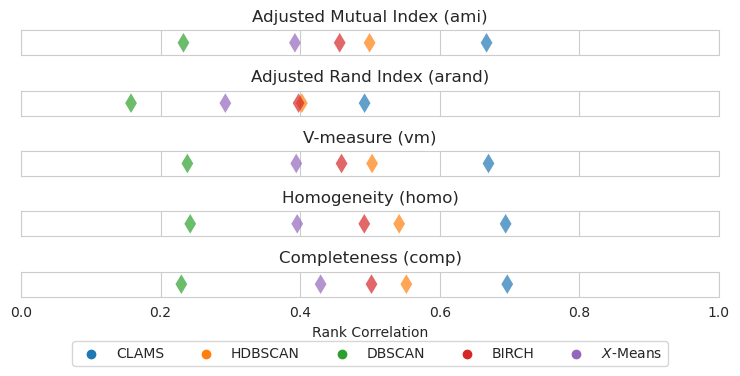

In [8]:
correlation = []
prediction = []
ground_truth = []

prediction_list = [
    ambiguities, hdbscan_ambiguity, dbscan_ambiguity, birch_ambiguity, xmeans_ambiguity
]
prediction_name_list = ["CLAMS", "HDBSCAN", "DBSCAN", "BIRCH", "$X$-Means"]

ground_truth_list = [
    ami_ambiguity_list, arand_ambiguity_list, v_measure_score_list, homo_score_list, comp_score_list
]
ground_truth_name_list = ["Adjusted Mutual Index (ami)", "Adjusted Rand Index (arand)", "V-measure (vm)", "Homogeneity (homo)", "Completeness (comp)"]

for i in range(len(prediction_list)):
  for j in range(len(ground_truth_list)):
    corr_val = spearmanr(prediction_list[i], ground_truth_list[j])[0]
    if corr_val < 0:
      corr_val = - corr_val
    correlation.append(corr_val)
    prediction.append(prediction_name_list[i])
    ground_truth.append(ground_truth_name_list[j])


df = pd.DataFrame({
		"Rank Correlation": correlation,
		"Prediction": prediction,
		"Ground Truth": ground_truth
})

sns.set_style("whitegrid")
fig, ax = plt.subplots(len(ground_truth_list), figsize=(7.5, 3.6), sharex=True)

for i in range(len(ground_truth_list)):
  sns.stripplot(
    df[df["Ground Truth"] == ground_truth_name_list[i]], 
    x="Rank Correlation", hue="Prediction", ax=ax[i], jitter=False, marker="d", s=10, alpha=0.7
	)
  ## set x range
  ax[i].set_xlim(0, 1)
  
  ax[i].set_title(ground_truth_name_list[i])
  
	## make legend in the bottom center 
  ax[i].get_legend().remove()
  if i == len(ground_truth_list) - 1:
    handles, labels = ax[i].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=5, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()

plt.savefig("./analysis_figures/amb_rank_corr.pdf", dpi=300, bbox_inches="tight")
plt.savefig("./analysis_figures/amb_rank_corr.png", dpi=300, 		bbox_inches="tight")

Mean correlation:  0.44394825707919133
Std correlation:  0.1769423800751527


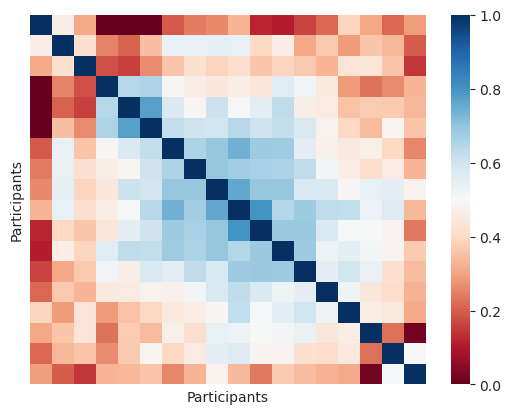

In [9]:
user_selected_ambiguity_list = []
for result in study_result:
	user_selected_ambiguity = np.zeros(len(keys))
	for i, key in enumerate(keys):
		user_selected_ambiguity[i] += int(result["ambiguity"][key])
	user_selected_ambiguity_list.append(user_selected_ambiguity)

user_selected_ambiguity_corr_matrix = np.zeros((len(user_selected_ambiguity_list), len(user_selected_ambiguity_list)))

corr_arr = []
for i in range(len(user_selected_ambiguity_list)):
	for j in range(0, i + 1):
		user_selected_ambiguity_corr_matrix[i, j] = spearmanr(user_selected_ambiguity_list[i], user_selected_ambiguity_list[j])[0]
		user_selected_ambiguity_corr_matrix[j, i] = user_selected_ambiguity_corr_matrix[i, j]
		if i != j:
			corr_arr.append(user_selected_ambiguity_corr_matrix[i, j])

linkage_mat = hierarchy.linkage(user_selected_ambiguity_corr_matrix, optimal_ordering=True)
ordering = hierarchy.leaves_list(linkage_mat)

# print(ordering)

usacm_reordered = user_selected_ambiguity_corr_matrix[ordering, :]
usacm_reordered = usacm_reordered[:, ordering]

print("Mean correlation: ", np.mean(corr_arr))
print("Std correlation: ", np.std(corr_arr))
sns.heatmap(usacm_reordered, cmap="RdBu", vmin=0, vmax=1)

plt.xticks([])
plt.yticks([])

plt.xlabel("Participants")
plt.ylabel("Participants")

plt.savefig("./analysis_figures/amb_corr_matrix.pdf", dpi=300)
plt.savefig("./analysis_figures/amb_corr_matrix.png", dpi=300)


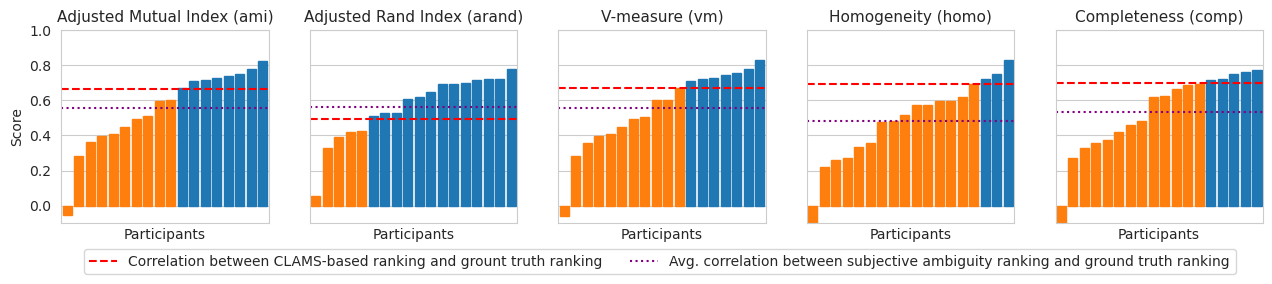

In [15]:



fig, ax = plt.subplots(1, 5, figsize=(15.5, 2.5), sharey=True)

for i, amb_list in enumerate(
    [ami_ambiguity_list, arand_ambiguity_list, v_measure_score_list, homo_score_list, comp_score_list]
):
  aginst_clams = spearmanr(ambiguities, amb_list)[0]
  against_user_selected_ambiguity = spearmanr(user_selected_ambiguity, amb_list)[0]
  
  corr_list = []
  for user_selected_ambiguity_single in user_selected_ambiguity_list:
    corr_list.append(spearmanr(amb_list, user_selected_ambiguity_single)[0])
  corr_list = np.array(corr_list)[np.argsort(corr_list)]
  bigger_than_clams = corr_list > aginst_clams
  sns.barplot(x=np.arange(len(corr_list)), y=corr_list, ax=ax[i])


  
	## change bar color that are bigger than clams
  for j, is_bigger in enumerate(bigger_than_clams):
    if is_bigger:
      ax[i].patches[j].set_color(sns.color_palette("tab10")[0])
    else:
      ax[i].patches[j].set_color(sns.color_palette("tab10")[1])
  ax[i].set_ylim(top=1)
  

  ax[i].axhline(aginst_clams, color="red", linestyle="dashed", label="Correlation between CLAMS-based ranking and grount truth ranking")
  ax[i].axhline(np.mean(corr_list), color="purple", linestyle="dotted", label="Avg. correlation between subjective ambiguity ranking and ground truth ranking")

  if i == 0:
    ax[i].legend(loc="upper left", bbox_to_anchor=(0.075, -0.1), ncol=2)
  ax[i].set_title(ground_truth_name_list[i], fontsize=11)
  ax[i].set_xticks([])
  
  ax[i].set_xlabel("Participants")
  if i == 0:
    ax[i].set_ylabel("Score")
  
	## remove margin between bars

# plt.tight_layout()


plt.savefig("./analysis_figures/amb_corr_bar.pdf", dpi=300, bbox_inches="tight")
plt.savefig("./analysis_figures/amb_corr_bar.png", dpi=300, bbox_inches="tight")
plt.show()

[0.99995777 0.88477545 0.65843415 0.23767588 0.88394184 0.63903525
 0.84900185 0.84615918 0.88317543 0.56839006 0.79770394 0.73411645
 0.6216849  0.6728777  0.73895027 0.70225396 0.80626341 0.55603592
 0.46329976 0.9188162  0.51408545 0.62650307 0.67131158 0.50083347
 0.43350744 0.62054685 0.67083099 0.58867302 0.4668663  0.54078836
 0.69252192 0.56239455 0.75128319 0.64564932 0.40005765 0.791513
 0.5677418  0.60007622 0.6702086  0.9527356  0.67232688 0.45476836
 0.43028143 0.45721441 0.53622831 0.69022621 0.57725692 0.3469634
 0.52570386 0.49169258 0.49696555 0.47715277 0.69910773 0.46518541
 0.56795598 0.5352419  0.49011389 0.64583591 0.41447629 0.61275578]


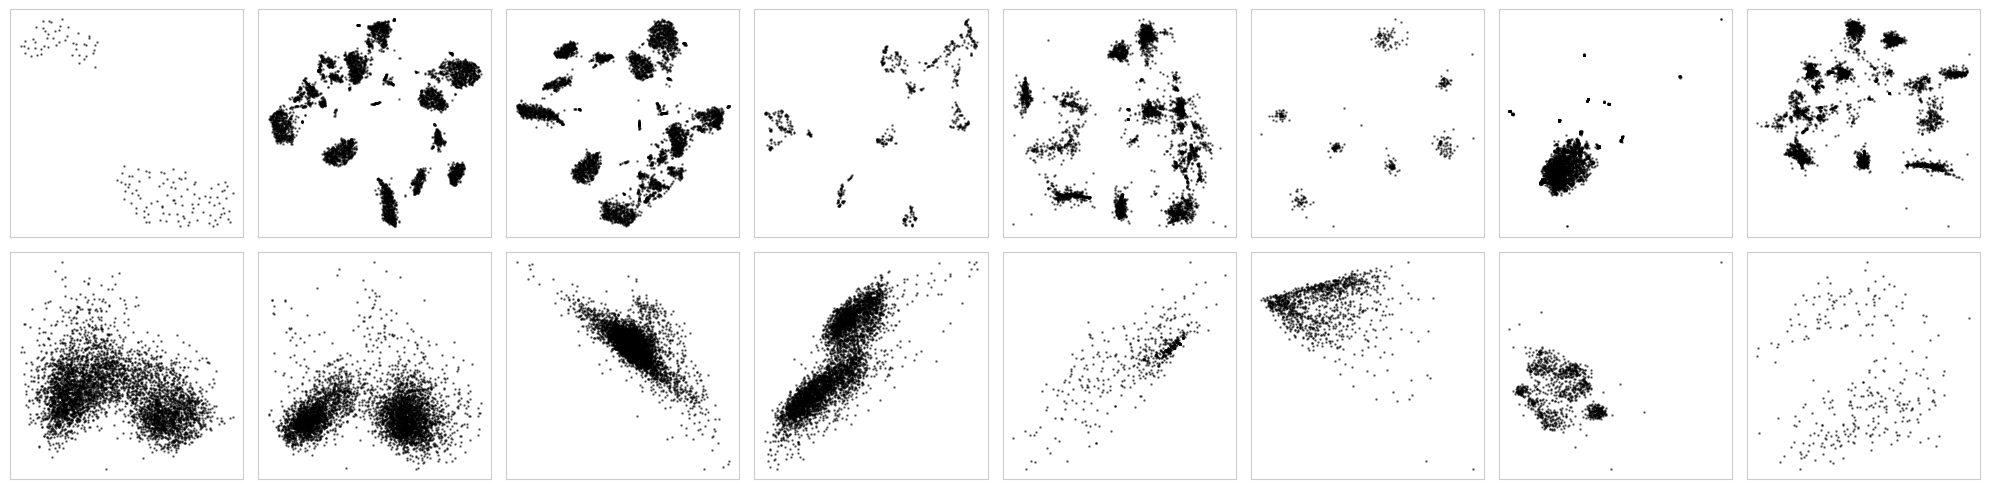

In [153]:
print(ambiguities)

keys_sort = np.array(keys)[np.argsort(ambiguities)]

top_six = keys_sort[:8]
bottom_six = keys_sort[-8:]

fig, ax = plt.subplots(2, 8, figsize=(20, 5))
for i, key in enumerate(top_six):
  splot = np.load(f"../scatterplots/scatterplots/{key}", allow_pickle=True)
  ax[0, i].scatter(splot[:, 0], splot[:, 1], s=0.7, alpha=0.5, c="black")
  
for i, key in enumerate(bottom_six):
  splot = np.load(f"../scatterplots/scatterplots/{key}", allow_pickle=True)
  ax[1, i].scatter(splot[:, 0], splot[:, 1], s=0.7, alpha=0.5, c="black")
  
for i in range(2):
  for j in range(8):
    # ax[i, j].spines["top"].set_visible(False)
    # ax[i, j].spines["right"].set_visible(False)
    # ax[i, j].spines["bottom"].set_visible(False)
    # ax[i, j].spines["left"].set_visible(False)
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    
plt.tight_layout()
plt.savefig("./figures/top_and_bottom.pdf", dpi=300)
plt.savefig("./figures/top_and_bottom.png", dpi=300)